In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import SimpleRNN, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import keras
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# set seed to reproduce similar results
np.random.seed(0)

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HAR/HAR/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HAR/HAR/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [3]:
trainX, trainy, testX, testy = load_dataset('D:/Son/3-2/deeplearning/report/dataset/')

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [4]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


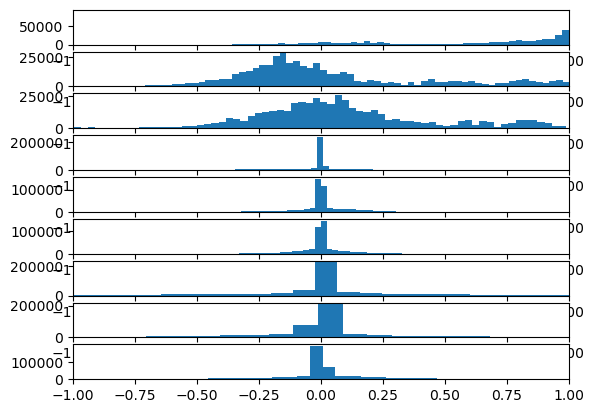

In [5]:
# plot distributions
plot_distributions(trainX)

In [6]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [7]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               44000     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 54,706
Trainable params: 54,706
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 14s 118ms/step - loss: 1.3169 - accuracy: 0.4329 - val_loss: 1.1089 - val_accuracy: 0.5534
Epoch 2/10
92/92 [==============================] - 10s 110ms/step - loss: 0.9187 - accuracy: 0.6157 - val_loss: 0.8557 - val_accuracy: 0.6621
Epoch 3/10
92/92 [==============================] - 10s 111ms/step - loss: 0.8493 - accuracy: 0.6257 - val_loss: 0.9554 - val_accuracy: 0.6533
Epoch 4/10
92/92 [==============================] - 10s 108ms/step - loss: 0.6914 - accuracy: 0.7114 - val_loss: 0.8042 - val_accuracy: 0.7390
Epoch 5/10
92/92 [==============================] - 10s 111ms/step - loss: 0.5644 - accuracy: 0.7936 - val_loss: 0.6610 - val_accuracy: 0.7797
Epoch 6/10
92/92 [==============================] - 10s 111ms/step - loss: 0.4368 - accuracy: 0.8476 - val_loss: 0.7214 - val_accuracy: 0.7077
Epoch 7/10
92/92 [==============================] - 10s 107ms/step - loss: 0.3997 - accuracy: 0.8446 - val_loss: 0.5227 - val_accuracy: 0.8423

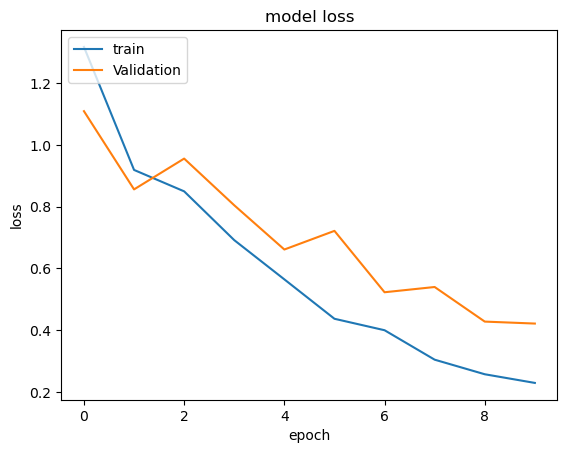

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [11]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the LSTM model 0.8608754873275757
93/93 [==============================] - 3s 22ms/step


In [12]:
predictions

array([[3.0160064e-03, 2.0566101e-03, 1.9465589e-04, 1.4443486e-02,
        9.8012519e-01, 1.6406087e-04],
       [1.7848513e-03, 1.2053136e-03, 9.5018055e-05, 1.0766017e-02,
        9.8605573e-01, 9.3067982e-05],
       [1.7050785e-03, 1.1424306e-03, 8.7103246e-05, 1.0209161e-02,
        9.8676831e-01, 8.8002678e-05],
       ...,
       [8.1197964e-03, 9.8636252e-01, 4.1979835e-03, 9.4366915e-06,
        1.3054238e-03, 4.7907597e-06],
       [1.4862439e-01, 7.6896560e-01, 2.5868734e-02, 1.0380762e-03,
        5.5272404e-02, 2.3080177e-04],
       [3.5263485e-01, 6.1290032e-01, 6.5986719e-03, 5.1552273e-04,
        2.7099561e-02, 2.5108882e-04]], dtype=float32)

In [13]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[458  16  22   0   0   0]
 [ 33 390  42   1   5   0]
 [ 16  45 357   0   2   0]
 [  0   1   0 381 109   0]
 [  5   7   0  73 447   0]
 [  0  17  16   0   0 504]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.89      0.92      0.91       496
           2       0.82      0.83      0.82       471
           3       0.82      0.85      0.83       420
           4       0.84      0.78      0.81       491
           5       0.79      0.84      0.82       532
           6       1.00      0.94      0.97       537

    accuracy                           0.86      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.86      0.86      0.86      2947



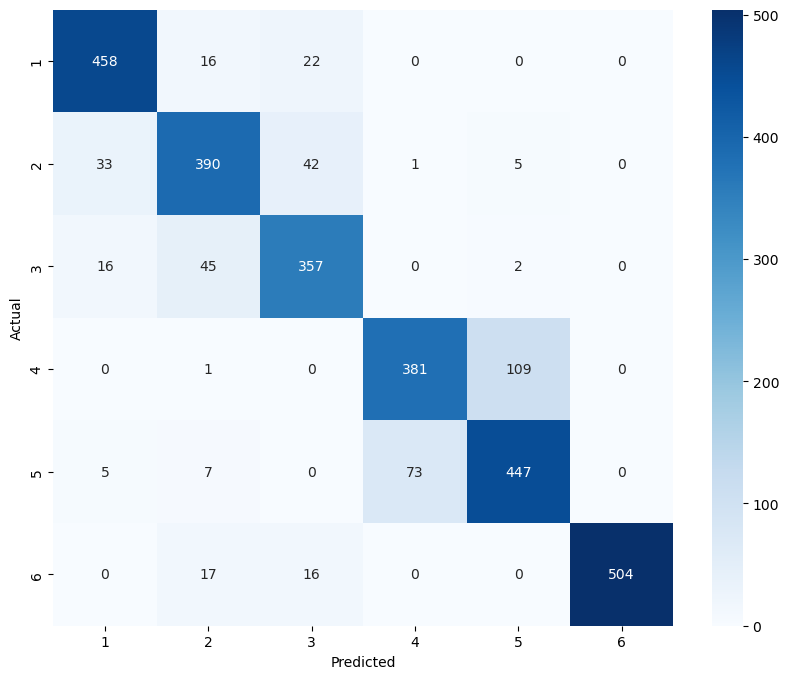

In [14]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

In [15]:
#CNN

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 125, 64)           2368      
                                                                 
 conv1d_1 (Conv1D)           (None, 122, 64)           16448     
                                                                 
 dropout_1 (Dropout)         (None, 122, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 61, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3904)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               390500    
                                                      

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 3s 27ms/step - loss: 0.5017 - accuracy: 0.8041 - val_loss: 0.5136 - val_accuracy: 0.8668
Epoch 2/20
92/92 [==============================] - 2s 24ms/step - loss: 0.1613 - accuracy: 0.9384 - val_loss: 0.4322 - val_accuracy: 0.8946
Epoch 3/20
92/92 [==============================] - 2s 25ms/step - loss: 0.1084 - accuracy: 0.9587 - val_loss: 0.4619 - val_accuracy: 0.9089
Epoch 4/20
92/92 [==============================] - 2s 25ms/step - loss: 0.0954 - accuracy: 0.9561 - val_loss: 0.5035 - val_accuracy: 0.9096
Epoch 5/20
92/92 [==============================] - 2s 24ms/step - loss: 0.0911 - accuracy: 0.9590 - val_loss: 0.4639 - val_accuracy: 0.9096
Epoch 6/20
92/92 [==============================] - 2s 24ms/step - loss: 0.0868 - accuracy: 0.9612 - val_loss: 0.5655 - val_accuracy: 0.8973
Epoch 7/20
92/92 [==============================] - 2s 25ms/step - loss: 0.0757 - accuracy: 0.9646 - val_loss: 0.5788 - val_accuracy: 0.9109
Epoch 8/20
92

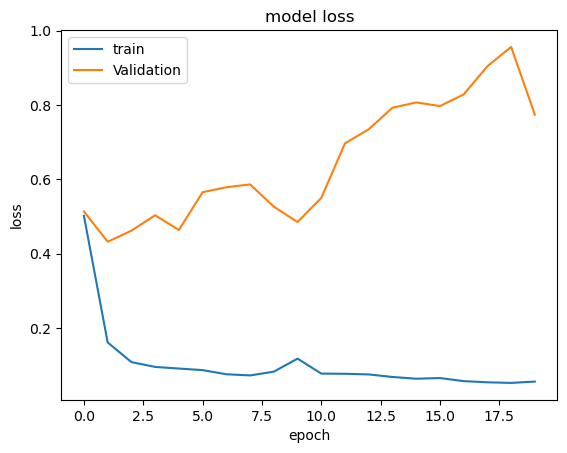

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [19]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the CNN model 0.898201584815979
93/93 [==============================] - 0s 3ms/step


**** Confusion Matrix ****
[[490   1   5   0   0   0]
 [ 47 390  34   0   0   0]
 [  0   1 419   0   0   0]
 [  2   8   0 429  52   0]
 [  1   1   0 105 425   0]
 [ 17  26   0   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.88      0.99      0.93       496
           2       0.91      0.83      0.87       471
           3       0.91      1.00      0.95       420
           4       0.80      0.87      0.84       491
           5       0.89      0.80      0.84       532
           6       1.00      0.92      0.96       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



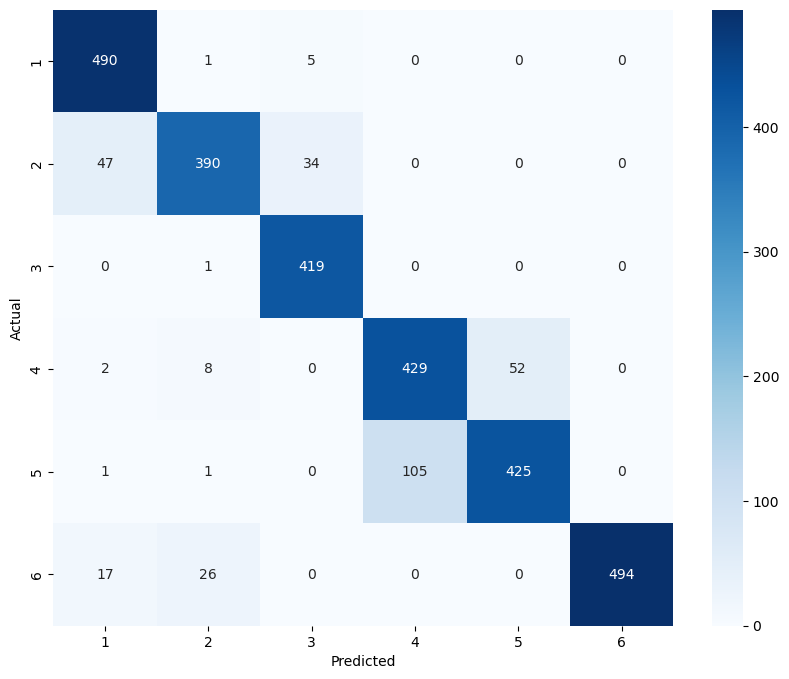

In [20]:
display_results(testy,predictions,classNames)

In [21]:
# we will select the first sample from the test set
sample = testX[0]
sample.shape

(128, 9)

In [22]:
# predict the results using the model, we need to input in the form of (numberOfSamples,featureLength,numberOfFeatures)
predictionForSample = model.predict(sample.reshape(1,sample.shape[0],sample.shape[1]))

1/1 [==============================] - 0s 28ms/step


In [23]:
# get the class of the sample
samplePredictedClass = np.argmax(predictionForSample, axis=1)
sampleActualClass = np.argmax(testy, axis=1)
print("Actual class: ",sampleActualClass[0])
print("Predicted class: ",samplePredictedClass[0])

Actual class:  4
Predicted class:  4
